In [2]:
import sys
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import winsound
from electron_rigol_class import *
from electron_RS_class import *
try:
    import TimeTagger
except:
    print ("Time Tagger lib is not in the search path.")
    pyversion = sys.version_info
    from winreg import ConnectRegistry, OpenKey, HKEY_LOCAL_MACHINE, QueryValueEx
    registry_path = "SOFTWARE\\Python\\PythonCore\\" + str(pyversion.major) + "." + str(pyversion.minor) + "\\PythonPath\\Time Tagger"
    reg = ConnectRegistry(None, HKEY_LOCAL_MACHINE)
    key = OpenKey(reg, registry_path) 
    module_path = QueryValueEx(key,'')[0]
    print ("adding " + module_path)
    sys.path.append(module_path)
    
from TimeTagger import createTimeTagger, Counter, Countrate, Histogram, LOW, HIGH, freeTimeTagger, scanTimeTagger, ConstantFractionDiscriminator
from time import sleep
from pylab import *
from pathlib import Path

###############################################################
###############################################################
save_date = '2020_05_28'
date = '20200528'
###############################################################
###############################################################

data_folder = r'C:\Users\cm467\Documents\Jupyter'
save_folder = data_folder + '/' + save_date + '/' + 'lifetime'

if os.path.exists(save_folder) == False:
    Path(save_folder).mkdir(parents=True, exist_ok=False)
    os.chdir(save_folder)
else:
    os.chdir(save_folder)

roi = []
variable = []
################################################################
################################################################

# print (scanTimeTagger())

# create a timetagger instance
tagger = createTimeTagger()
# print (scanTimeTagger())
tagger.reset()
trigger = 0.5
tagger.setTriggerLevel(2, trigger)
tagger.setDeadtime(2, 100000)
# Ch2_CFD = ConstantFractionDiscriminator(tagger,[2], search_window = 10000)
# CFD_channels = Ch2_CFD.getChannels()

# Rigol
sampling_time = 100.E-9
rigol =  rigol(sampling_time)

# R&S
# rs = RS()


###############################
# Set up experiment: variable parameters
###############################
U2 = -0.7
Prf = +5.0
Ex = -0.01
Ey = 0.0
Ez=-0.15
U1=0.2
# parameters for the Rigol waveforms
# trap frequency stuff:
# freq_trapfreq = 1E5 # parameters for trap freq. measurement
# frequencies = np.arange(30, 250, 1) * 1E6
# amp_trapfreq = -9.0

pulse_width_ao = 100 * 1.E-6
# pulse_width_loading = np.arange(10, 210, 10) * 1.E-6
# wait_time = 500.E-6
# wait_times = [wait_time]
wait_times = np.logspace(3, 6, 10) * 1E-6
# wait_times = np.array([200, 350, 500]) * 1E-3
wait_times_random = wait_times
print (wait_times)
np.random.shuffle(wait_times_random)
print (wait_times_random)

pulse_delay_ao = sampling_time
pulse_width_ej = 20.E-9
pulse_delay_ej = 2.E-9 

exp_cycles = 5E2  # how many experiment repetitions
################################
# for pulse_width_ao in pulse_width_loading:
for wait_time in wait_times:
# cycle_duration,wait_time_corr = rigol.run(pulse_width_ao, pulse_delay_ao, pulse_width_ej, pulse_delay_ej, wait_time)
# for freq_trapfreq in frequencies:
    # program and switch on Rigol, returns repetition period in s
    cycle_duration,wait_time_corr = rigol.run(pulse_width_ao, pulse_delay_ao, pulse_width_ej, pulse_delay_ej, wait_time)
#     rs.run(freq_trapfreq,amp_trapfreq)
#     print (cycle_duration)
    filename = date + '_lifetime_U2_' + str("{:.2f}".format(U2))+'_U1_' + str("{:.2f}".format(U1))  +'_Ex' + str("{:.2f}".format(Ex)) +'_Ey' + str("{:.2f}".format(Ey))+'_Ez' + str("{:.2f}".format(Ez)) + '_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tload' + str("{:n}".format(pulse_width_ao/1E-6)) + 'us_Tej' \
    + str("{:n}".format(pulse_width_ej/1E-9)) + 'ns_wait' + str("{:n}".format(wait_time_corr/1E-6)) + 'us_reps'+ \
    str("{:.1e}".format(exp_cycles)) +'_trigger' + str("{:.1f}".format(trigger))+ 'CFD_off_+300V.txt'
#     print (filename)
    ###############################
    # set up time tagger histogram and take data
    bwidth = 500
#     print (cycle_duration/binwidth*1E12 - 100)
    n_bin = int(500*(1000/bwidth))
    histo = Histogram(tagger, click_channel = 2, start_channel = 1, binwidth = bwidth, n_bins = n_bin)
#     histo = Histogram(tagger, click_channel = CFD_channels[0], start_channel = 1, binwidth = bwidth, n_bins = n_bin)
    tagger.sync()
    histo.clear()
#     print (cycle_duration * exp_cycles)
    sleep(cycle_duration * exp_cycles)
    data = histo.getData()
    
    ###############################
    roi_start = int(80 * 1000/bwidth)
    roi_stop = int(130 *1000/bwidth)
    # save data
    x_data = np.arange(0, n_bin) * bwidth/1000
    file_data = np.array([x_data[0:1000], data[0:1000]])
#     file_data = np.array([x_data, data])
    file_data = file_data.T
#     print (file_data)
    np.savetxt(filename, file_data, delimiter=',')
    print (wait_time*1E3, np.sum(data[roi_start:roi_stop]))
#     print (freq_trapfreq/1E6, np.sum(data[roi_start:roi_stop]))
#     print (pulse_width_ao, np.sum(data[roi_start:roi_stop]))
    roi = np.append(roi, np.sum(data[roi_start:roi_stop]))
#     variable = np.append(variable, freq_trapfreq)
    variable = np.append(variable, wait_time)
#     variable = np.append(variable, pulse_width_ao)


filename_roi = date + '_lifetime_ROI_U2_' + str("{:.2f}".format(U2))+'_U1_' + str("{:.2f}".format(U1)) +'_Ex' + str("{:.2f}".format(Ex)) +'_Ey' + str("{:.2f}".format(Ey)) +'_Ez' + str("{:.2f}".format(Ez))+'_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tej' \
    + str("{:n}".format(pulse_width_ej/1E-9)) + 'ns_wait' + str("{:n}".format(wait_time_corr/1E-6)) + 'us_Tload' + str("{:n}".format(pulse_width_ao/1E-6)) + 'us_' + 'reps'+ \
    str("{:.1e}".format(exp_cycles)) + '_trigger' + str("{:.1f}".format(trigger))+ 'CFD_off_+300V.txt'
ROI_data = np.array([variable,roi])
ROI_data = ROI_data.T 
np.savetxt(filename_roi,ROI_data,delimiter=',')
os.chdir(data_folder)

frequency = 440  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)


[0.001      0.00215443 0.00464159 0.01       0.02154435 0.04641589
 0.1        0.21544347 0.46415888 1.        ]
[0.46415888 0.1        0.00464159 0.00215443 0.01       0.02154435
 0.04641589 0.001      1.         0.21544347]
464.1588833612772 18
99.99999999999999 15
4.6415888336127775 162
2.1544346900318847 165
10.0 139
21.54434690031882 111
46.41588833612772 35
1.0 155
1000.0 8
215.4434690031882 11


[0.33020309 0.0340464  0.01951782]
[0.01808429 0.00582518 0.01224747]


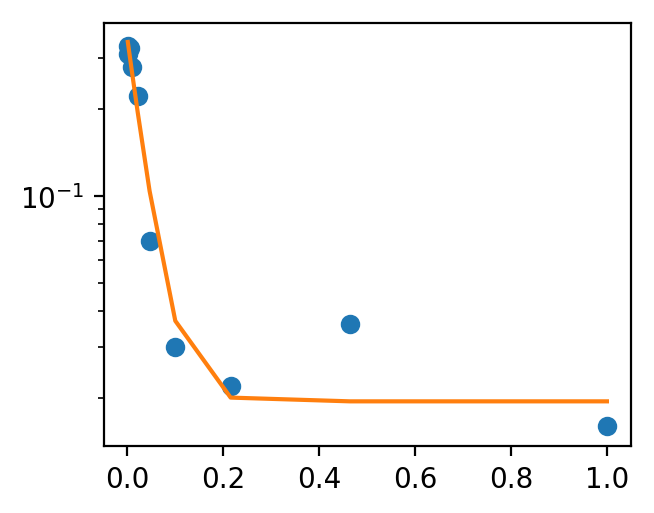

In [3]:
from scipy.optimize import curve_fit
def exp(time, amp, tau, offset):
    return amp * np.exp(-time/tau) + offset

sorting_indices = np.argsort(variable)
variable = variable[sorting_indices]
P_det = roi/exp_cycles
P_det = P_det[sorting_indices]

popt, pcov = curve_fit(exp, variable, P_det, p0 = [600, 0.04, 10])
fit_errors = np.sqrt(np.diag(pcov))
print (popt)
print (fit_errors)

plt.figure(figsize = (3.4,2.8), dpi = 200)
plt.semilogy(variable,P_det, 'o')
plt.semilogy(variable, exp(variable, *popt))
# plt.ylim(1E0,1E3)
plt.show()
# scanTimeTagger()
# freeTimeTagger(tagger)
# scanTimeTagger()
# tagger.reset()

[1.23568977 0.02679623 0.06402118]
[0.01808429 0.00582518 0.01224747]


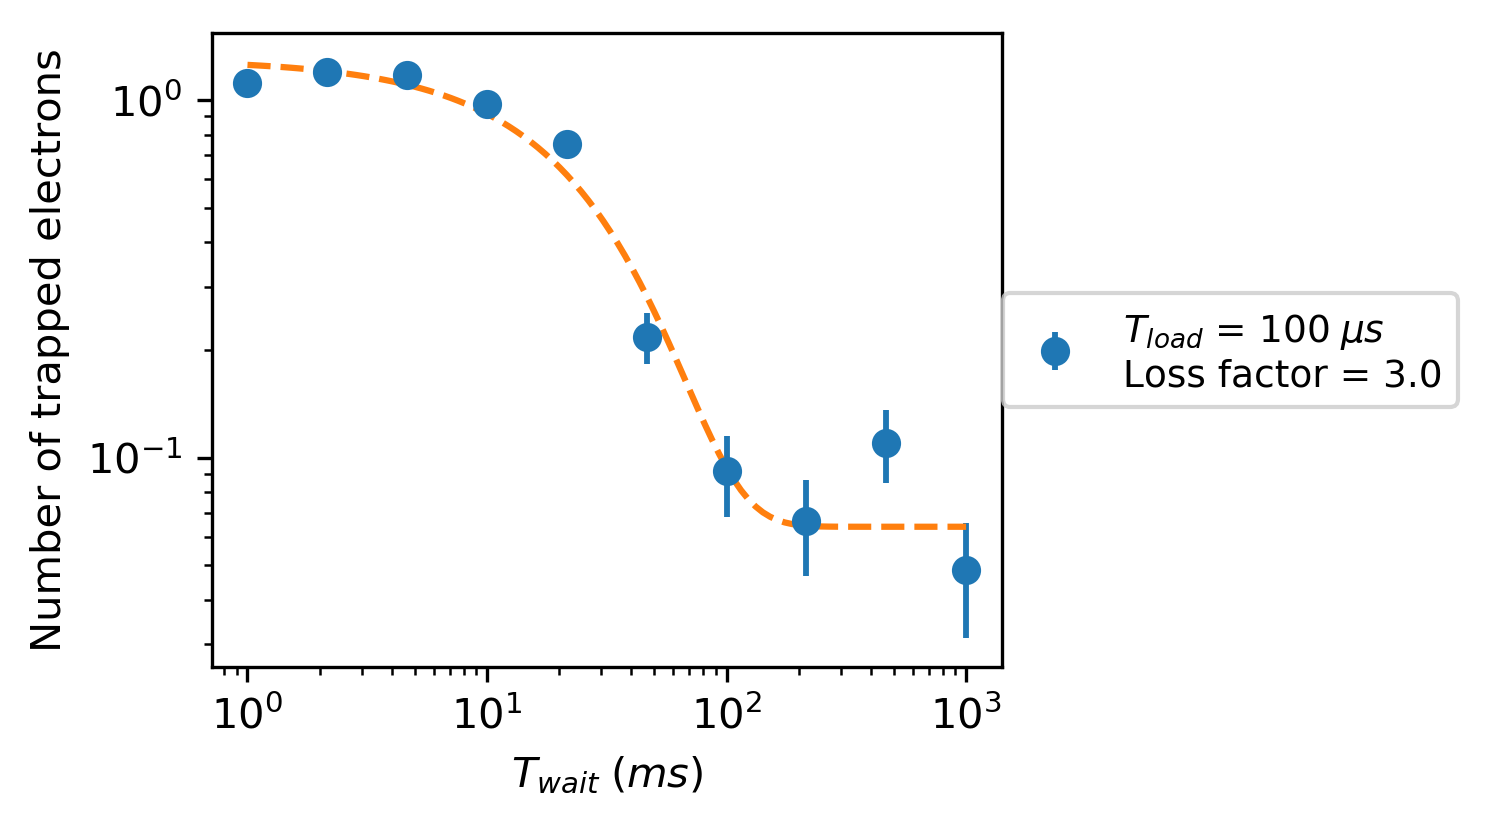

In [4]:
os.chdir(save_folder)
from scipy import special
loss = 3
def P_distribution(detections, lambda_P):
    return lambda_P ** detections * np.exp(-lambda_P) / (special.factorial(detections))

def number_conversion(detection_probability):
    lambdas = np.arange(0,30,0.0001)
    min_index = np.argmin(np.abs(P_distribution(0, lambdas) - (1-detection_probability)))
#     print (lambdas[min_index])
    return lambdas[min_index]


P_det_error = np.sqrt(roi[sorting_indices])/exp_cycles

electron_number = [(number_conversion(P_det[i])) * loss for i in range(len(P_det))]
number_error = [(number_conversion(P_det_error[i])) * loss for i in range(len(P_det))]
number_error = np.array(number_error)
for i in range(len(number_error)):
    if number_error[i] == 0:
        number_error[i] = 1

popt, pcov = curve_fit(exp, variable[:], electron_number[:],sigma = number_error[:], absolute_sigma = True, p0 = [1, 10, 0.06], bounds = ([0,0,0.01],[500, 1000, 2]))
print (popt)
print (fit_errors)

file_name_png = filename_roi[:-4]
filename_roi = date + '_lifetime_ROI_U2_' + str("{:.2f}".format(U2)) +'_Ex' + str("{:.2f}".format(Ex)) +'_Ez' + str("{:.2f}".format(Ez))+'_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tej' \
    + str("{:n}".format(pulse_width_ej/1E-9)) + 'ns_wait' + str("{:n}".format(wait_time_corr/1E-6)) + 'us_Tload' + str("{:n}".format(pulse_width_ao/1E-6)) + 'us_' + 'reps'+ \
    str("{:.1e}".format(exp_cycles)) + '_trigger' + str("{:.1f}".format(trigger))+ 'CFD_off_'+'_refocus.txt'
label = '$T_{load}$ = ' + str("{:n}".format(pulse_width_ao/1E-6)) + '$\;\mu s$' \
        '\n' + 'Loss factor = ' + str("{:.1f}".format(loss))


time_cont = np.logspace(0, 3, 100)/1000
fig, ax1 = plt.subplots(figsize = (3.4, 2.8), dpi = 300)
ax1.errorbar(variable*1000, electron_number, yerr = number_error, fmt = 'o', linewidth = 1.4, label = label)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('$T_{wait}\;(ms)$')
ax1.set_ylabel('Number of trapped electrons')
plt.loglog(time_cont*1000, exp(time_cont, *popt),'--')
plt.legend(fontsize = 9, loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.savefig(file_name_png + '.png', bbox_inches = 'tight')
plt.show()

os.chdir(data_folder)